# Community detection Examples
Let's visualize the community structure of graphs using the Leiden algorithm built-in to `igraph`.


In [5]:
import igraph as ig
import xnetwork as xn
import pandas as pd
import igraph as ig
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud

This finds the communities using the Leiden algorithm, which is a popular method for community detection in networks. It tries to optimize modularity, a measure of the strength of division of a network into communities. Nodes in the same community are more densely connected to each other than to nodes in other communities.


In [44]:
def leidenMemberships(g):
    return g.community_leiden("modularity").membership

Let's load the climate citation network.

In [22]:
# Loading a citation network
g = ig.Graph.Read_GML("../../Datasets/Networks/MAG-Climate-2020.gml").simplify() # adjust path as needed
# Let's make it undirected for simplicity
g = g.as_undirected()
#attributes:
print(g.vertex_attributes())

['id', 'KCoreAll', 'KCoreIN', 'doctype', 'papertitle', 'rank', 'year']


Let's record this as an attribute in the graph.

In [45]:
g.vs["Community"] = leidenMemberships(g)

Let's use the visualization function we defined earlier.

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_igraph_with_matplotlib(
    g,
    layout,
    node_size=300,
    node_color="skyblue",
    node_alpha=1.0,
    edge_color="gray",
    edge_width=1.0,
    edge_alpha=0.7,
    with_labels=False,
    label_attr="label",
    label_font_size=10,
    label_color="black",
    figsize=(6, 6),
    dpi=100,
    axis_off=True
):
    """
    Draw an igraph Graph `g` using matplotlib, given `layout`.
    
    Parameters
    ----------
    g : igraph.Graph
      The graph to draw.
    layout : Layout or sequence of (x, y)
      An igraph Layout object or list/array of coordinate pairs.
    node_size : float
      Size of the nodes (passed to plt.scatter `s`).
    node_color : color or list of colors
      Node face color.
    node_alpha : float
      Node transparency (0.0 transparent, 1.0 opaque).
    edge_color : color
      Color for all edges.
    edge_width : float
      Line width for edges.
    edge_alpha : float
      Edge transparency.
    with_labels : bool
      Whether to draw vertex labels.
    label_attr : str
      Vertex attribute name to use for labels; if absent, vertex indices used.
    label_font_size : float
      Font size for labels.
    label_color : color
      Color for label text.
    figsize : tuple
      Matplotlib figure size.
    dpi : int
      Figure DPI.
    axis_off : bool
      If True, hides axes.
    """
    # extract coordinates as an (N,2) array
    coords = np.array(layout.coords) if hasattr(layout, "coords") else np.array(layout)
    xs, ys = coords[:, 0], coords[:, 1]

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # draw edges
    for src, tgt in g.get_edgelist():
        x0, y0 = coords[src]
        x1, y1 = coords[tgt]
        ax.plot(
            [x0, x1],
            [y0, y1],
            color=edge_color,
            linewidth=edge_width,
            alpha=edge_alpha,
            zorder=1
        )

    # draw nodes
    ax.scatter(
        xs,
        ys,
        s=node_size,
        c=node_color,
        alpha=node_alpha,
        zorder=2,
        edgecolors="black"
    )

    # draw labels
    if with_labels:
        if label_attr in g.vs.attribute_names():
            labels = g.vs[label_attr]
        else:
            labels = [str(i) for i in range(g.vcount())]
        for idx, label in enumerate(labels):
            ax.text(
                xs[idx],
                ys[idx],
                label,
                fontsize=label_font_size,
                color=label_color,
                ha="center",
                va="center",
                zorder=3
            )

    if axis_off:
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

We can use wordclouds to visualize the words in the communities. This code will calculate the relative frequency of each word in the communities and then plot a word cloud for each community. The size of each word in the cloud corresponds to its frequency in the community subtracted by the frequency in the entire graph.

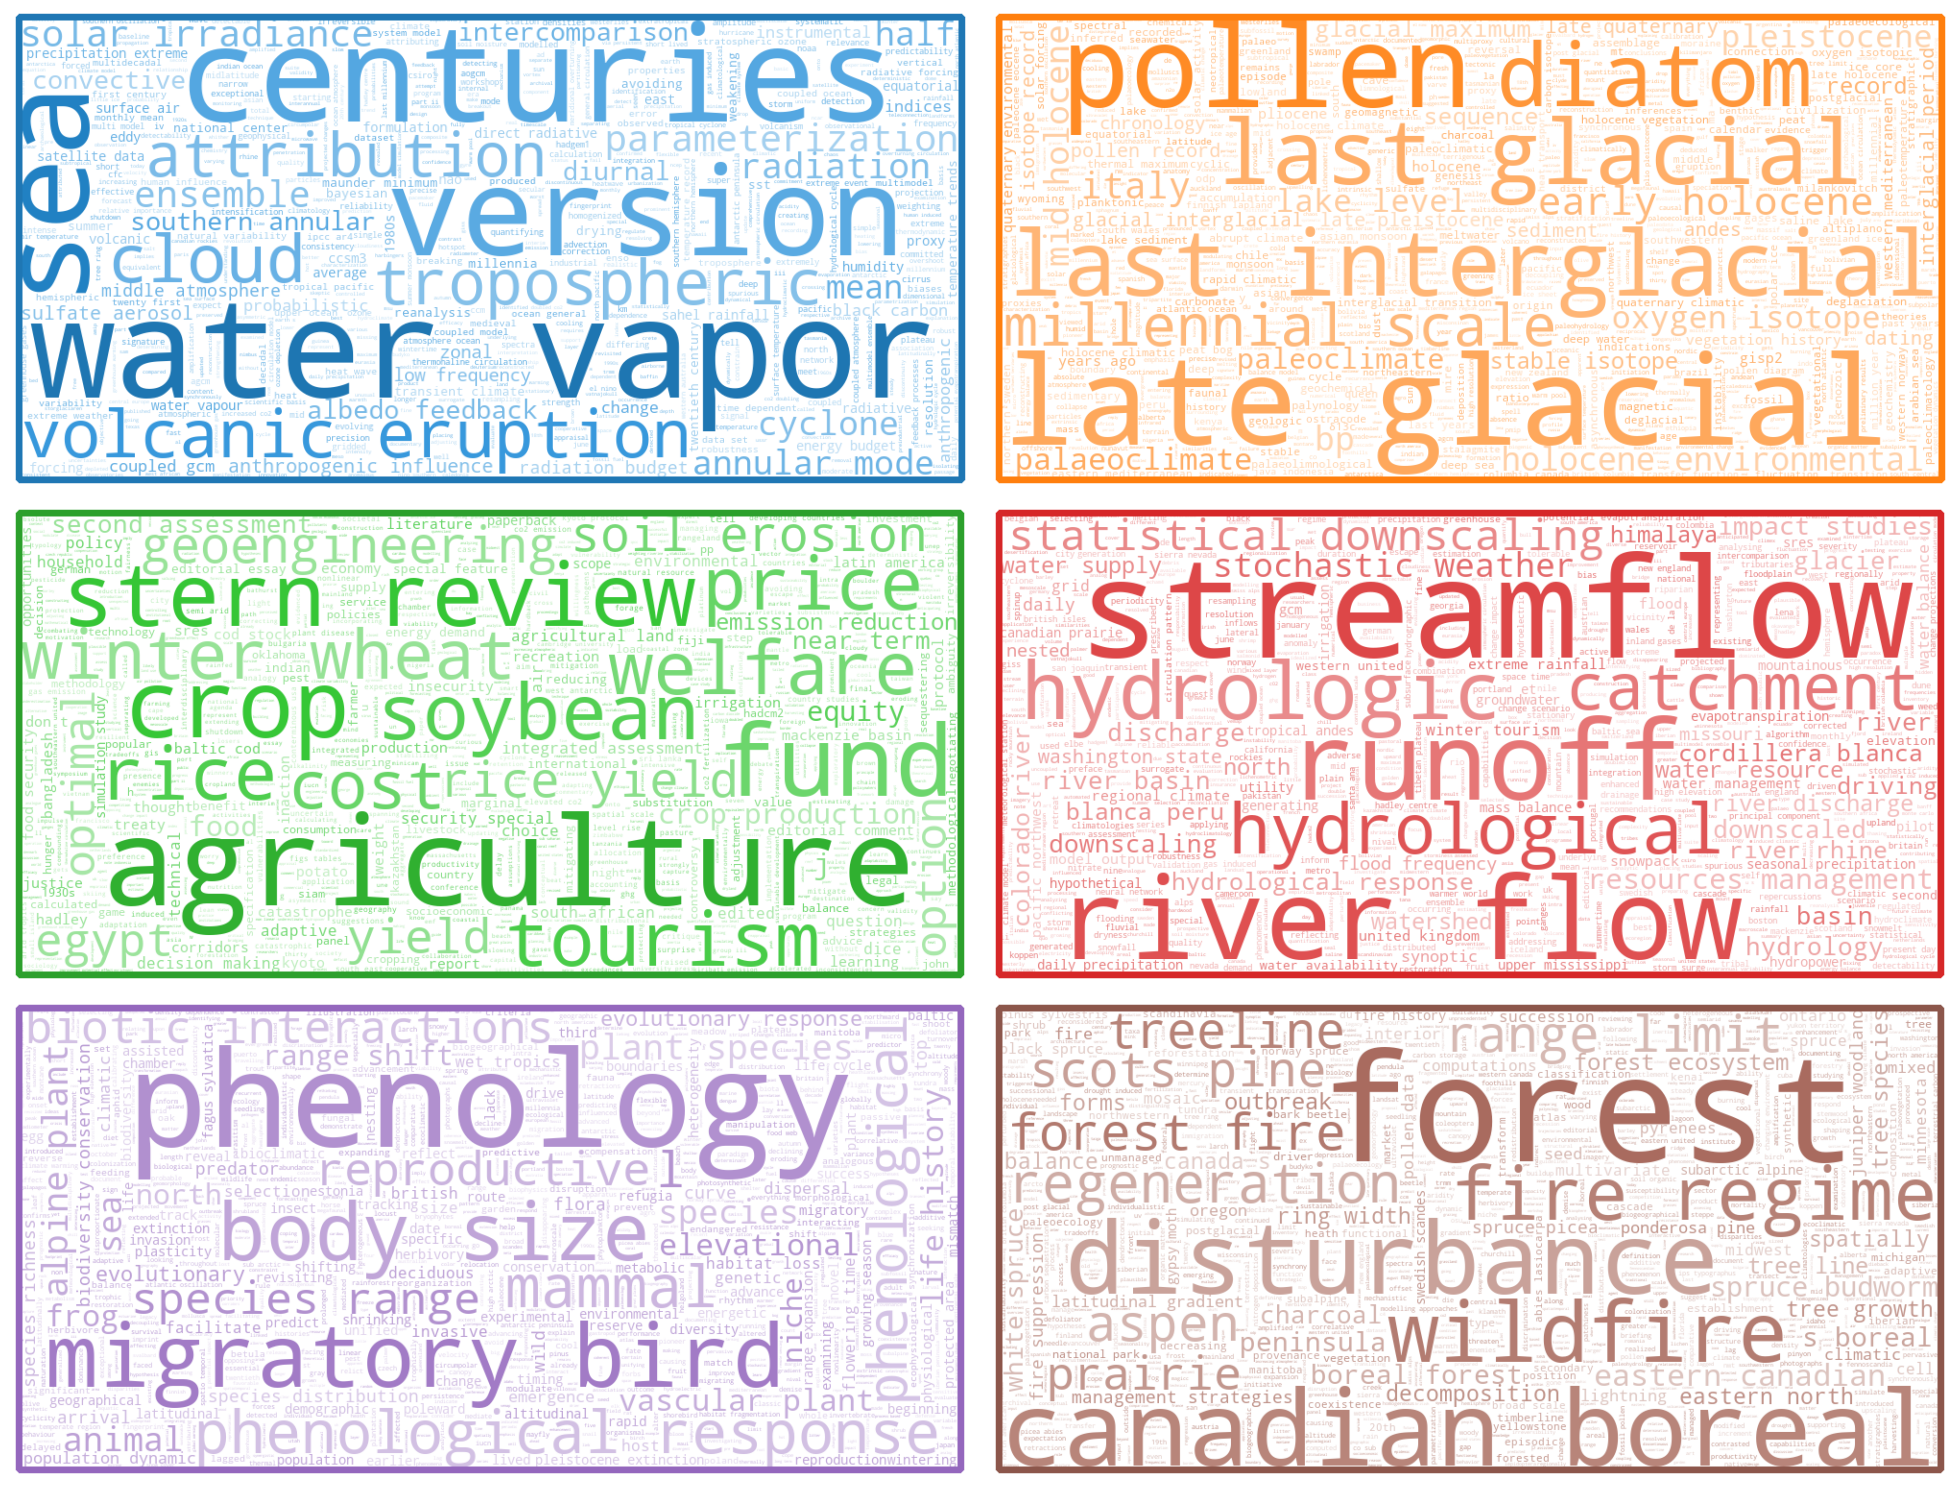

In [47]:

def lighten_color(color, amount=0.5):
	"""
	Lightens the given color by multiplying (1-luminosity) by the given amount.
	Input can be matplotlib color string, hex string, or RGB tuple.
	
	Examples:
	>> lighten_color('g', 0.3)
	>> lighten_color('#F034A3', 0.6)
	>> lighten_color((.3,.55,.1), 0.5)
	"""
	import matplotlib.colors as mc
	import colorsys
	try:
		c = mc.cnames[color]
	except:
		c = color
	c = colorsys.rgb_to_hls(*mc.to_rgb(c))
	return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


def generateColorFunction(originalColor):
	def lighten_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
		c = lighten_color(originalColor,font_size/200*0.6+0.2+0.4*random.random())
		return (int(c[0]*255),int(c[1]*255),int(c[2]*255))
	return lighten_color_func


def sortByFrequency(arr):
	s = set(arr)
	keys = {n: (-arr.count(n), arr.index(n)) for n in s}
	return sorted(list(s), key=lambda n: keys[n])
 

import math
import random

_styleColors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf","#aec7e8","#ffbb78","#98df8a","#ff9896","#c5b0d5","#c49c94","#f7b6d2","#c7c7c7","#dbdb8d","#9edae5"];

maxInternalWords = 10000
maxAllWords = 10000
maxCommunities = 6

communities = g.vs["Community"]
sortedCommunities = sortByFrequency(communities)[0:maxCommunities]
fig = plt.figure(figsize=(20,5*math.ceil(len(sortedCommunities)/2)))
allTitles = "\n".join(g.vs["papertitle"])
allFrequencies = WordCloud(max_words=maxAllWords).process_text(allTitles)
amask = np.zeros((500,1000),dtype='B')
amask[:10,:] = 255
amask[-10:,:] = 255
amask[:,:10] = 255
amask[:,-10:] = 255
for index,community in enumerate(sortedCommunities):
	communityColor = (_styleColors[index] if index<len(_styleColors) else "#aaaaaa")
	titles = "\n".join([vertex["papertitle"] for vertex in g.vs if vertex["Community"]==community])
	plt.subplot(math.ceil(len(sortedCommunities)/2),2,index+1)
	wc = WordCloud(background_color="white", max_words=maxInternalWords, width=1000,height=500,
		mask=amask,contour_width=10, contour_color=communityColor,random_state=3,color_func=generateColorFunction(communityColor))
	totalTitles = len(titles.split("\n"))
	inCommunityFrequency = wc.process_text(titles)
	relativeFrequencies = {key:frequency/totalTitles/(allFrequencies[key]-frequency+1) for key,frequency in inCommunityFrequency.items() if key in allFrequencies and allFrequencies[key]>frequency}
	wc.generate_from_frequencies(relativeFrequencies)
	
	plt.imshow(wc, interpolation='bilinear')
	plt.axis("off")
		
plt.tight_layout()
# plt.savefig("wordcloud.pdf")
plt.show()
# plt.close(fig)

Let's now visualize the network with colors indicating the communities. We will use the LGL (Large Graph Layout) algorithm for layout, which is suitable for large graphs. It will take some time to compute the layout for large graphs.


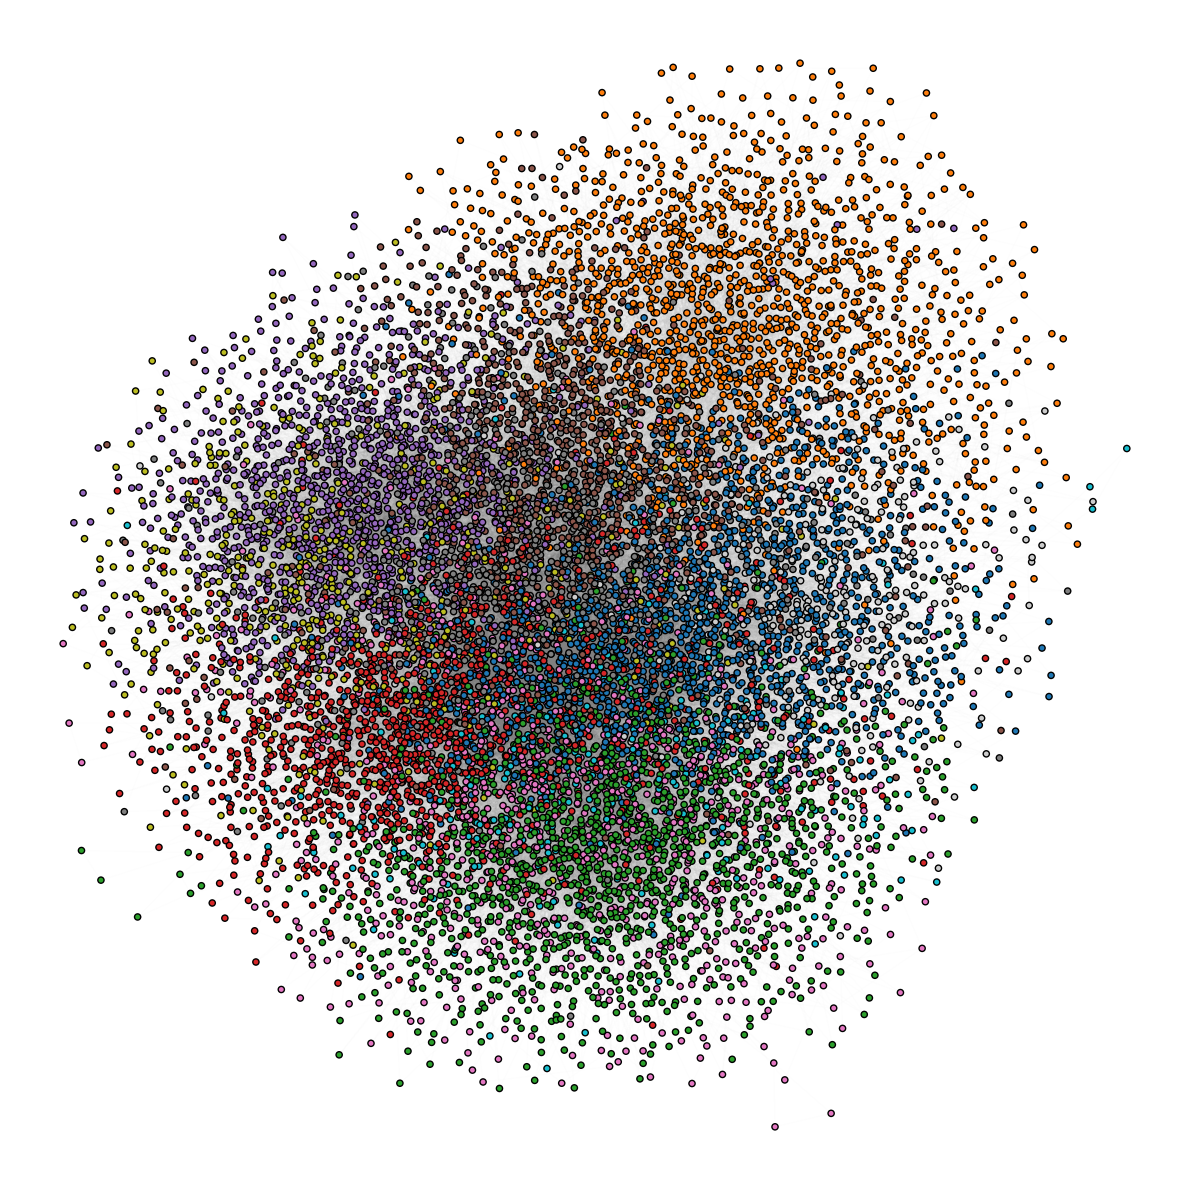

In [ ]:
# color countries
from collections import Counter
community2Index = {community:index for index,(community,_) in enumerate(Counter(g.vs["Community"]).most_common(10))}
communityColors = [mpl.cm.tab10(community2Index[community]) if community in community2Index else "#cccccc" for community in g.vs["Community"]]
# use lgl layout
layout = g.layout("lgl")
# plot the graph
plot_igraph_with_matplotlib(
    g,
    layout,
    node_size=20,
    node_color=communityColors,
    edge_color="gray",
    edge_alpha=0.05,
    with_labels=False,
    figsize=(12, 12),
    dpi=100
)

You can also visualize these using Helios-Web, just save it as .xnet following the Visualize class materials.